In [1]:
%pylab inline
from qick import *
from tqdm.notebook import tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
soc = QickSoc()
soccfg = soc
print(soc)


QICK configuration:

	Board: RFSoC4x2

	Global clocks (MHz): tProcessor 350.000, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 0, ch 0, 32-bit DDS, fabric=614.400 MHz, fs=9830.400 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=614.400 MHz, fs=9830.400 MHz

	2 readout channels:
	0:	axis_readout_v2 - controlled by PYNQ
		ADC tile 0, ch 0, 32-bit DDS, fabric=491.520 MHz, fs=3932.160 MHz
		maxlen 1024 (avg) 16384 (decimated), trigger bit 4, tProc input 0
	1:	axis_readout_v2 - controlled by PYNQ
		ADC tile 0, ch 1, 32-bit DDS, fabric=491.520 MHz, fs=3932.160 MHz
		maxlen 1024 (avg) 16384 (decimated), trigger bit 5, tProc input 1

	2 DACs:
		DAC tile 0, ch 0 is DAC_B
		DAC tile 2, ch 0 is DAC_A

	2 ADCs:
		ADC tile 0, ch 0 is ADC_D
		ADC tile 0, ch 1 is ADC_C

	4 digital output pins (tProc output 7):
	0:	PMOD0_0
	1:	PMOD0_1
	2:	PMOD0_2
	3

In [3]:
config = {
 'res_ch': 0,
 'qubit_ch': 1,
    
 'readout_length': soccfg.us2cycles(600*0.001, gen_ch=0),
 'f_res': 7371.8,
 'res_phase': 0,
 'adc_trig_offset': 200,
 'res_gain': int(0.046*32000),
    
 'pi_gain': int(0.05*32000),
 'pi2_gain': int(0.05*32000/2),
 'f_ge': 5541.94,
 'len': 30*0.001,
    
 'relax_delay': 100_000*0.001,
    
 'start': 0,
 'step': soccfg.us2cycles(100*0.001),
    
 'phase_step': soccfg.deg2reg(np.degrees(1), 0),
    
 'expts': 100,
 'reps': 10,
 'rounds': 200}

In [4]:
class RamseyProgramSlow(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(cfg["qubit_ch"])     # get register page for qubit_ch
        self.wait = cfg["wait"]
        
        self.declare_gen(ch=cfg["res_ch"], nqz=2) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["res_ch"])
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        self.f_ge = f_ge
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=f_ge, phase=0,
                                 gain=cfg["pi2_gain"],
                                 length=self.soccfg.us2cycles(cfg["len"], gen_ch=cfg["qubit_ch"]))
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"])        
        
        self.sync_all(self.us2cycles(0.2))
    
    def body(self):        
        self.pulse(ch=self.cfg["qubit_ch"], t=0)  #play probe pulse
        
        self.set_pulse_registers(ch=self.cfg["qubit_ch"], style="const", freq=self.f_ge, phase=self.cfg["phase"],
                                 gain=self.cfg["pi2_gain"], 
                                 length=self.soccfg.us2cycles(self.cfg["len"], gen_ch=self.cfg["qubit_ch"]))
        
        self.pulse(ch=self.cfg["qubit_ch"], t=self.soccfg.us2cycles(self.cfg["len"])+self.wait)  #

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0],
             t=2*self.soccfg.us2cycles(self.cfg["len"])+self.wait,
             adc_trig_offset=2*self.soccfg.us2cycles(self.cfg["len"])+self.wait+self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        

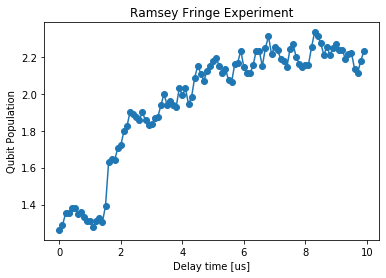

In [5]:
res = []
for i, w in enumerate(np.arange(0, config["step"]*config["expts"], config["step"])):
    config["wait"] = w
    config["phase"] = soccfg.deg2reg(np.degrees(1*i), 0)
    config["off"] = soccfg.deg2reg(np.degrees(1*i), 0)
    t2p=RamseyProgramSlow(soccfg, config)
    avgi, avgq= t2p.acquire(soc, load_pulses=True,progress=False, debug=False)
    res.append(np.abs(avgi[0][0]+avgq[0][0]*1j))
    
subplot(111, title="Ramsey Fringe Experiment", xlabel="Delay time [us]", ylabel="Qubit Population")
plt.plot(soccfg.cycles2us(np.arange(0, config["step"]*config["expts"], config["step"])), res,'o-')

In [6]:
class RamseyProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(cfg["qubit_ch"])
        self.r_wait = 3
        self.r_phase2 = 4
        self.r_phase=self.sreg(cfg["qubit_ch"], "phase")
        self.regwi(self.q_rp, self.r_wait, cfg["start"])
        self.regwi(self.q_rp, self.r_phase2, 0)
        
        self.declare_gen(ch=cfg["res_ch"], nqz=2)
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) 
        
        for ch in [0,1]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["res_ch"])
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0)
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])


        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=f_ge, phase=0,
                                 gain=cfg["pi2_gain"], 
                                 length=self.soccfg.us2cycles(self.cfg["len"], gen_ch=self.cfg["qubit_ch"]))
        
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"],
                                 gain=cfg["res_gain"], length=cfg["readout_length"])        
        
        self.sync_all(self.us2cycles(0.2))
    
    def body(self):
        self.regwi(self.q_rp, self.r_phase, 0)
        
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.mathi(self.q_rp, self.r_phase, self.r_phase2,"+",0)
        self.sync_all()
        self.sync(self.q_rp,self.r_wait)

        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all()

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', self.cfg["step"]) # update the time between two π/2 pulses
        self.mathi(self.q_rp, self.r_phase2, self.r_phase2, '+', self.cfg["phase_step"]) # advance the phase of the LO for the second π/2 pulse

  0%|          | 0/200 [00:00<?, ?it/s]

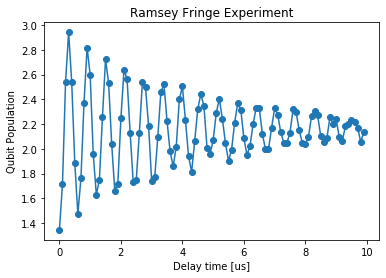

In [7]:
t2p=RamseyProgram(soccfg, config)
x_pts, avgi, avgq= t2p.acquire(soc, load_pulses=True,progress=True, debug=False)

subplot(111, title="Ramsey Fringe Experiment", xlabel="Delay time [us]", ylabel="Qubit Population")
plot(soccfg.cycles2us(x_pts),np.abs(avgi[0][0]+avgq[0][0]*1j),'o-')